In [1]:
import csv
import pandas as pd

def load_data(filename):
    reader = csv.DictReader(open(filename, 'r'))
    rows = []
    for row in reader:
        float_keys = [
            'price',
            'market_cap',
            'total_volume',
            '1d_ta',
            '7d_ta',
            '30d_ta',
        ]
        for key in float_keys:
            if key not in row:
                continue
            if not row[key]:
                row[key] = 0
            else:
                row[key] = float(row[key])
        rows.append(row)
    return rows

eth_usd_rows = load_data('eth_usd.csv')

In [2]:
def compute_net_apy(rows, from_date, num_days, staked_eth, ltv, apy):
    count = 0
    usd_loaned = None
    usd_yield = 0.0
    for row in rows:
        if row['date'] < from_date:
            continue

        # compute initial USD loaned
        if usd_loaned is None:
            usd_loaned = row['price'] * ltv * staked_eth

        # compute profits for that day
        delta_eth = staked_eth * apy * (1/365)
        delta_usd = delta_eth * row['price']
        usd_yield += delta_usd

        count += 1
        if count >= num_days:
            break

    net_apy = (usd_yield * (365/count)) / usd_loaned
    return net_apy

compute_net_apy(
    eth_usd_rows,
    '2019-12-01',
    10,
    10,   # staked eth
    0.5,  # LTV
    0.04  # apy
)


0.0783164472989154

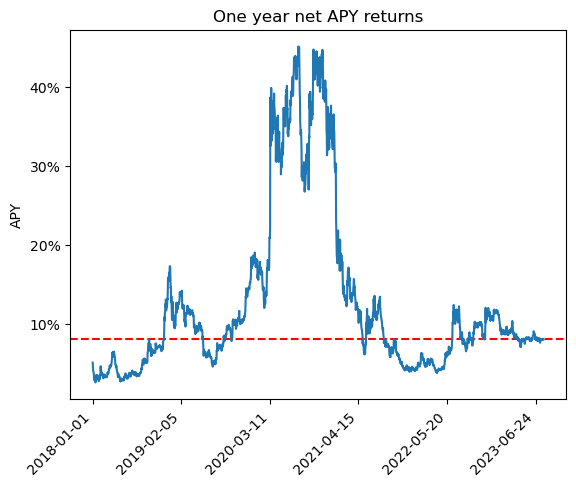

In [53]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


def analysis_1(rows, num_days):
    from_date = '2018-01-01'
    results = []
    for row in rows:
        if row['date'] < from_date:
            continue
        net_apy = compute_net_apy(
            rows,
            row['date'],
            num_days,
            10,
            0.5,
            0.04
        )
        result = {'date': row['date'], 'net_forward_apy': net_apy}
        results.append(result)
    return results


def pre_format_plt():
    fig, ax = plt.subplots()
    ax.set_title('One year net APY returns')
    ax.set_ylabel('APY')
    ax.get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(
            lambda x, p: '%.0f%%' % (x*100)
        )
    )
    plt.axhline(y=0.08, color='r', linestyle='--')
    return fig, ax

def post_format_plt(ax):
    ax.set(xticks=ax.get_xticks()[::400],
           xticklabels=ax.get_xticklabels()[::400])
    plt.xticks(rotation=45, ha='right')

yield_loan_results = analysis_1(eth_usd_rows, 360)
ylr = pd.json_normalize(yield_loan_results)

fig, ax = pre_format_plt()
plt.plot(ylr['date'], ylr['net_forward_apy'])
post_format_plt(ax)

plt.show()

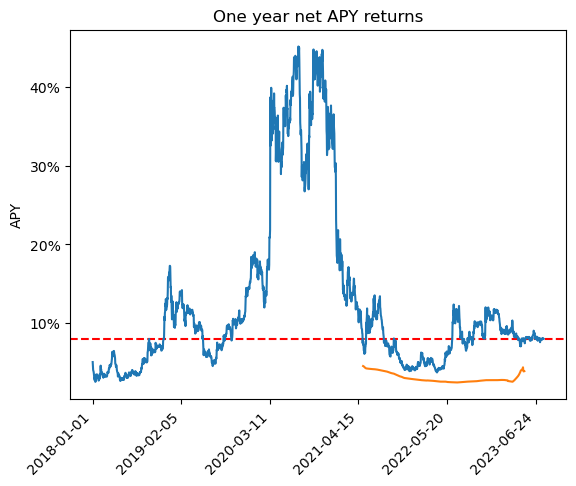

In [54]:
def compute_net_apy_aave(rows, from_date, num_days):
    usd_initial = 100.0
    usd_net = usd_initial
    count = 0

    for row in reversed(rows):
        if row['date'] < from_date:
            continue
        incr = usd_net * (row['1d_ta'] / 100) * (1/365)
        usd_net += incr
        count += 1
        if count >= num_days:
            break

    delta = usd_net - usd_initial
    net_apy = (delta * (365/count)) / usd_initial
    return net_apy


def analysis_2_aave(rows, num_days):
    from_date = '2021-05-06'
    initial_amount = 1.0
    results = []
    for row in reversed(rows):
        if row['date'] < from_date:
            continue

        net_apy_aave = compute_net_apy_aave(
            rows,
            row['date'],
            num_days)
        
        result = {'date': row['date'], 'net_forward_apy': net_apy_aave}
        results.append(result)
    return results

rows_aave = load_data('aave_apy.csv')
results_aave = analysis_2_aave(rows_aave, 365) 
aave_df = pd.json_normalize(results_aave)

fig, ax = pre_format_plt()
plt.plot(ylr['date'], ylr['net_forward_apy'])
plt.plot(aave_df['date'], aave_df['net_forward_apy'])
post_format_plt(ax)

plt.show()

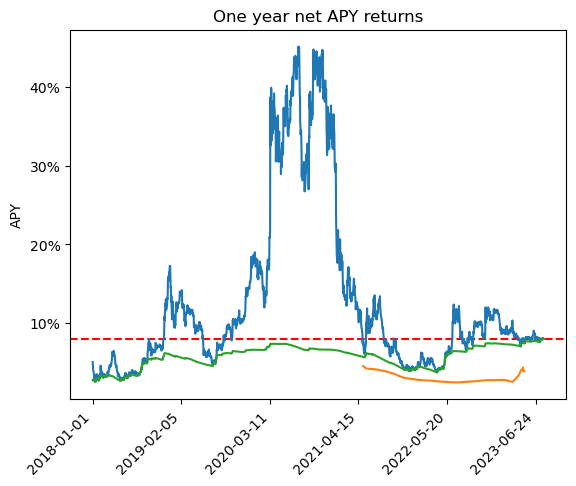

In [55]:
def compute_net_apy_refinance(rows, from_date, num_days, staked_eth, ltv, apy, funding_rate=0.0):
    count = 0
    usd_loaned = None
    usd_refinanced = 0
    usd_yield = 0.0
    for row in rows:
        if row['date'] < from_date:
            continue

        max_loan = row['price'] * ltv * staked_eth

        if usd_loaned is None:
            usd_loaned = max_loan

        if max_loan > (usd_loaned + usd_refinanced):
            usd_refinanced += max_loan - (usd_loaned + usd_refinanced)

        funding_cost = 0
        funding_cost_eth = 0
        eth_value = staked_eth * row['price']
        actual_ltv = (usd_loaned + usd_refinanced) / eth_value
        if actual_ltv > ltv:
            rate = funding_rate * (actual_ltv - ltv)
            if rate > funding_rate * 2:
                rate = funding_rate * 2
            funding_cost_eth = rate * (1/365) * staked_eth
            funding_cost = funding_cost_eth * row['price']

        # compute profits for that day
        delta_eth = staked_eth * apy * (1/365)
        delta_usd = delta_eth * row['price']
        usd_yield += delta_usd * (usd_loaned / (usd_loaned + usd_refinanced))

        if funding_cost:
            # print('usd_yield', usd_yield, funding_cost)
            usd_yield += funding_cost
            staked_eth -= funding_cost_eth

        count += 1
        if count >= num_days:
            break

    net_apy = (usd_yield * (365/count)) / usd_loaned
    return (net_apy, staked_eth)

def analysis_3(rows, num_days):
    from_date = '2018-01-01'
    results = []
    staked_eth = 10
    lowest_ending_staked_eth = staked_eth
    for row in rows:
        if row['date'] < from_date:
            continue

        (net_apy, end_staked_eth) = compute_net_apy_refinance(
            rows,
            row['date'],
            num_days,
            staked_eth,
            0.5,
            0.04
        )
        if end_staked_eth < lowest_ending_staked_eth:
            lowest_ending_staked_eth = end_staked_eth
        result = {'date': row['date'], 'net_forward_apy': net_apy}
        results.append(result)
    return (results, lowest_ending_staked_eth)


(ylr_refinance, _) = analysis_3(eth_usd_rows, 360)
refinance_df = pd.json_normalize(ylr_refinance)

fig, ax = pre_format_plt()
plt.plot(ylr['date'], ylr['net_forward_apy'])
plt.plot(aave_df['date'], aave_df['net_forward_apy'])
plt.plot(refinance_df['date'], refinance_df['net_forward_apy'])
post_format_plt(ax)

plt.show()


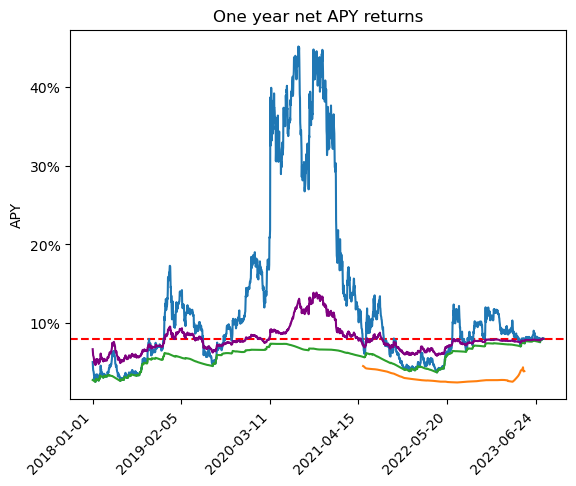

lowest ending lowest_steth: 9.483319879620616


In [56]:
def analysis_4(rows, num_days):
    from_date = '2018-01-01'
    results = []
    staked_eth = 10
    lowest_ending_staked_eth = staked_eth
    for row in rows:
        if row['date'] < from_date:
            continue

        (net_apy, end_staked_eth) = compute_net_apy_refinance(
            rows,
            row['date'],
            num_days,
            staked_eth,
            0.5,
            0.04,
            funding_rate=0.04
        )
        if end_staked_eth < lowest_ending_staked_eth:
            lowest_ending_staked_eth = end_staked_eth
        result = {'date': row['date'], 'net_forward_apy': net_apy}
        results.append(result)
    return (results, lowest_ending_staked_eth)


(ylr_refinance, _) = analysis_3(eth_usd_rows, 360)
(ylr_refinance_funding, lowest_steth) = analysis_4(eth_usd_rows, 360)
refinance_df = pd.json_normalize(ylr_refinance)
refinance_funding_df = pd.json_normalize(ylr_refinance_funding)

fig, ax = pre_format_plt()
plt.plot(ylr['date'], ylr['net_forward_apy'])
plt.plot(aave_df['date'], aave_df['net_forward_apy'])
plt.plot(refinance_df['date'], refinance_df['net_forward_apy'])
plt.plot(refinance_funding_df['date'], refinance_funding_df['net_forward_apy'], color='purple')
post_format_plt(ax)
plt.show()

print('lowest ending lowest_steth:', lowest_steth)